In [32]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import contextily as ctx
import requests
from shapely.geometry import Point
from datetime import datetime
from tqdm import tqdm
import time
from collections import defaultdict
import seaborn as sns
from prophet import Prophet
from scipy.optimize import curve_fit
import numpy as n
from scipy.interpolate import CubicSpline
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import pickle
from scipy.stats import linregress
import ipyparallel as ipp
import numpy as np
from pykrige.ok import OrdinaryKriging
import matplotlib as mpl
from pyproj import Transformer

In [2]:
def fetch_counts_for_year(year):
    counts_for_year = defaultdict(int)
    offset = 0
    limit = 10000
    while True:
        url = (
            f"https://data.cnra.ca.gov/api/3/action/datastore_search?"
            f"resource_id=bfa9f262-24a1-45bd-8dc8-138bc8107266"
            f"&q={year}&limit={limit}&offset={offset}"
        )
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data['result']['records']
            for record in records:
                site_code = record.get('site_code')
                if record.get('gse_gwe') is None:
                    continue
                if site_code:
                    counts_for_year[site_code] += 1
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Failed to fetch data for year {year}")
            break
    return counts_for_year

rc = ipp.Client()
dview = rc[:]

with dview.sync_imports():
    import requests
    from collections import defaultdict

dview.push({'fetch_counts_for_year': fetch_counts_for_year})

years = list(range(2008, 2025))

async_results = dview.map_async(fetch_counts_for_year, years)
results = async_results.get()

counts = defaultdict(lambda: defaultdict(int))
for year, year_counts in zip(years, results):
    for site_code, count in year_counts.items():
        counts[site_code][year] = count

obs_df = pd.DataFrame.from_dict(counts, orient='index')
obs_df = obs_df.fillna(0).astype(int)
obs_df.columns = [f'observations_{year}' for year in obs_df.columns]
obs_df = obs_df.reset_index().rename(columns={'index': 'site_code'})

importing requests on engine(s)
importing defaultdict from collections on engine(s)


In [3]:
central = pd.read_csv("../data/central_stations_observations.csv")
cent_5021 = central[central.Basin_Subb.str.startswith("5-021")]

In [4]:
observation_columns = [col for col in obs_df.columns if col.startswith('observations_')]
ov25 = obs_df[obs_df[observation_columns].ge(25).all(axis=1)]

In [5]:
ov25_5021 = ov25[ov25.site_code.isin(cent_5021.site_code)].copy()

In [6]:
def fetch_all_records(site_code, year):
    all_records = []
    offset = 0
    limit = 1000
    while True:
        url = f"https://data.cnra.ca.gov/api/3/action/datastore_search?resource_id=bfa9f262-24a1-45bd-8dc8-138bc8107266&q={site_code} {year}&limit={limit}&offset={offset}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data['result']['records']
            all_records.extend(records)
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Failed to fetch data for {site_code} in {year}")
            break
    return all_records

def get_readings_for_site(site_code, years):
    all_readings = []
    for year in years:
        records = fetch_all_records(site_code, year)
        for record in records:
            reading = {
                'site_code': record.get('site_code'),
                'msmt_date': record.get('msmt_date'),
                'wlm_rpe': record.get('wlm_rpe'),
                'wlm_gse': record.get('wlm_gse'),
                'gwe': record.get('gwe')
            }
            all_readings.append(reading)
    return pd.DataFrame(all_readings)

def interpolate_gwe(site_code, years, readings_df):
    site_data = readings_df
    site_data.rename(columns={"msmt_date": "ds", "gwe": "y"}, inplace=True)
    site_data['ds'] = pd.to_datetime(site_data['ds'])

    full_date_range = pd.date_range(start=f"{min(years)}-01-01", end=f"{max(years)}-12-31", freq="D")
    full_df = pd.DataFrame({'ds': full_date_range})
    full_df = full_df.merge(site_data, on='ds', how='left')

    m = Prophet(
        changepoint_prior_scale=0.01,
        seasonality_prior_scale=0.01,
        yearly_seasonality=True
    )
    m.fit(site_data.dropna())

    forecast = m.predict(full_df)

    full_df['y_interpolated'] = forecast['yhat']

    result_df = full_df[['ds', 'y_interpolated']].copy()
    result_df.rename(columns={"ds": "date", "y_interpolated": "gwe_interpolated"}, inplace=True)

    return result_df

def gwe_trend(site_code, start_yr, end_yr):
    years = range(start_yr, end_yr + 1)
    readings_df = get_readings_for_site(site_code, years)
    predicted = interpolate_gwe(site_code, years, readings_df)

    predicted['date'] = pd.to_datetime(predicted['date'])
    predicted.set_index('date', inplace=True)

    monthly_avg = predicted.resample('M').mean()
    
    return monthly_avg

In [7]:
client = ipp.Client()
dview = client[:]
dview.push({'fetch_all_records': fetch_all_records,
           'get_readings_for_site':get_readings_for_site,
           'interpolate_gwe':interpolate_gwe,
           'gwe_trend':gwe_trend})

dview.execute("""
import pandas as pd
import requests
from prophet import Prophet
import logging
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
""")

view = client.load_balanced_view()

well_gwe_trends = {}

def process_well(well):
    return well, gwe_trend(well, 2008, 2024)

async_results = []
for well in ov25_5021.site_code.unique():
    async_result = view.apply_async(process_well, well)
    async_results.append(async_result)

for async_result in async_results:
    try:
        well, result = async_result.get()
        well_gwe_trends[well] = result
    except Exception as e:
        print(f"Error processing well {well}: {e}")

In [8]:
def calculate_groundwater_changes(data_dict):
    result_dict = {}
    for year in range(2008, 2024):
        year_dict = {}

        for site_code, df in data_dict.items():
            try:
                october_value = df.loc[f'{year}-10-31'].iloc[0]
                september_value = df.loc[f'{year+1}-09-30'].iloc[0]
                change = october_value - september_value
                year_dict[site_code] = change
            except KeyError:
                print(f"Warning: Missing data for site {site_code} in year {year} or {year+1}.")
                year_dict[site_code] = None

        result_dict[year] = year_dict

    return result_dict

In [9]:
well_changes = calculate_groundwater_changes(well_gwe_trends)

In [10]:
def get_precipitation_data(latitude, longitude, start_date, end_date, parameter="PRECTOTCORR"):
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    
    params = {
        "parameters": parameter,
        "community": "AG",
        "longitude": longitude,
        "latitude": latitude,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    response = requests.get(base_url, params=params)
    response.raise_for_status()

    data = response.json()

    try:
        precip_data = data["properties"]["parameter"][parameter]
    except KeyError as e:
        raise ValueError(f"Unable to retrieve parameter '{parameter}' from response: {e}")

    return precip_data

def process_precipitation_data(precip_data):
    df = pd.DataFrame.from_dict(precip_data, orient="index", columns=["precipitation"])
    df.index = pd.to_datetime(df.index)
    monthly_avg = df.resample("M").mean()
    
    return monthly_avg

def get_monthly_precipitation_for_sites(df, start_date=2008, end_date=2024):
    result_dict = {}

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing sites"):
        site_code = row["site_code"]
        latitude = row["latitude"]
        longitude = row["longitude"]

        try:
            precip_data = get_precipitation_data(latitude, longitude, start_date, end_date)
            monthly_avg = process_precipitation_data(precip_data)
            result_dict[site_code] = monthly_avg

        except Exception as e:
            print(f"Error processing site {site_code}: {e}")
            result_dict[site_code] = None

    return result_dict

In [11]:
ov25_5021 = pd.merge(ov25_5021, central[["site_code", "latitude", "longitude", "well_depth"]], on="site_code", how="inner")

In [12]:
precipitation_data = get_monthly_precipitation_for_sites(ov25_5021)

Processing sites: 100%|██████████| 168/168 [05:45<00:00,  2.05s/it]


In [13]:
def calculate_annual_precipitation_averages(precipitation_dict):
    result_dict = {}
    for year in range(2008, 2024):
        year_dict = {}
        for site_code, monthly_avg in precipitation_dict.items():
            if monthly_avg is not None:
                try:
                    start_date = f"{year}-10-31"
                    end_date = f"{year+1}-09-30"
                    period_data = monthly_avg.loc[start_date:end_date]
                    average_precip = period_data["precipitation"].mean()
                    year_dict[site_code] = average_precip
                except KeyError:
                    print(f"Warning: Missing data for site {site_code} in year {year}.")
                    year_dict[site_code] = None
        result_dict[year] = year_dict
    return result_dict

In [14]:
well_precipitation = calculate_annual_precipitation_averages(precipitation_data)

In [15]:
wells = {}
for year, sites in well_precipitation.items():
    for site, precip in sites.items():
        wells.setdefault(site, []).append((year, precip))

SD_beneath = {}
for site, values in wells.items():
    precip_values = [precip for _, precip in values]
    mean_val = np.mean(precip_values)
    std_val = np.std(precip_values)
    threshold = mean_val - 0.5 * std_val
    SD_beneath[site] = [year for year, precip in values if precip < threshold]

In [16]:
gradients = {}
for site, years in SD_beneath.items():
    x = []
    y = []
    for year in years:
        if (year in well_precipitation and site in well_precipitation[year] and
            year in well_changes and site in well_changes[year]):
            x.append(well_precipitation[year][site])
            y.append(well_changes[year][site])
    if len(x) > 1:
        reg_result = linregress(x, y)
        gradients[site] = {"slope": reg_result.slope, "p_value": reg_result.pvalue}
    else:
        gradients[site] = {"slope": None, "p_value": None}

In [17]:
ov25_5021['gradient'] = ov25_5021['site_code'].map(lambda x: gradients.get(x, {}).get("slope", None))

In [18]:
SGMA = "../data/GWBasins.shp"
gdf = gpd.read_file(SGMA)
gdf.set_crs(epsg=3857, inplace=True)
gdf.set_index('OBJECTID', inplace=True)
gdf['Basin_Prefix'] = gdf['Basin_Numb'].str.split('-').str[0].astype(int)

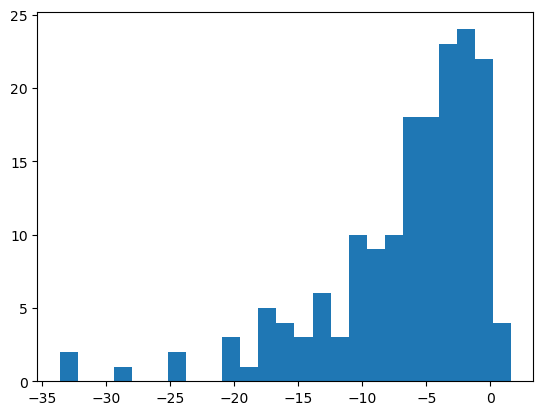

In [19]:
plt.hist(ov25_5021.gradient, bins=25)
plt.show()

In [20]:
stations_5021 = central[central.Basin_Subb.str.startswith("5-021")]
# stations_5021 = stations_5021[~stations_5021.well_depth.isna()]

In [21]:
stations_5021.describe()

latitude    longitude   well_depth  observations_2010  \
count  2102.000000  2102.000000  2102.000000        2102.000000   
mean     39.059757  -121.789005   343.488582          45.272122   
std       0.507967     0.284595   279.618111         112.279091   
min      38.113000  -122.453250     0.000000           0.000000   
25%      38.667457  -122.025050   150.000000           0.000000   
50%      38.924650  -121.797000   277.500000           2.000000   
75%      39.457030  -121.564923   460.000000           3.000000   
max      40.265170  -121.116900  2370.000000         391.000000   

       observations_2011  observations_2012  observations_2013  \
count        2102.000000        2102.000000        2102.000000   
mean           51.145576          59.457659          62.273549   
std           120.488541         130.964692         131.374413   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             2.000000           2.000000           2.000000   
75%             4.000000           7.000000          12.000000   
max           384.000000         379.000000         396.000000   

       observations_2014  observations_2015  observations_2016  \
count        2102.000000        2102.000000        2102.000000   
mean           60.556613          61.324453          57.588011   
std           126.815255         124.794012         123.436166   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             3.000000           3.000000           2.000000   
75%            22.000000          24.000000          12.000000   
max           402.000000         425.000000         425.000000   

       observations_2017  observations_2018  observations_2019  \
count        2102.000000        2102.000000        2102.000000   
mean           52.891056          57.567555          55.440533   
std           119.770680         124.415549         124.190926   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             2.000000           2.000000           2.000000   
75%             9.000000          17.000000          10.000000   
max           421.000000         425.000000         423.000000   

       observations_2020  observations_2021  observations_2022  \
count        2102.000000        2102.000000        2102.000000   
mean           58.331113          62.497146          64.044244   
std           123.012704         127.562469         131.348204   
min             0.000000           0.000000           0.000000   
25%             0.000000           1.000000           1.000000   
50%             3.000000           3.000000           3.000000   
75%            22.000000          28.750000          25.000000   
max           429.000000         488.000000         756.000000   

       observations_2023  observations_2024  
count        2102.000000        2102.000000  
mean           64.086108          58.764034  
std           134.498397         121.280839  
min             0.000000           0.000000  
25%             0.000000           0.000000  
50%             2.000000           2.000000  
75%            12.000000          11.000000  
max          1283.000000         382.000000

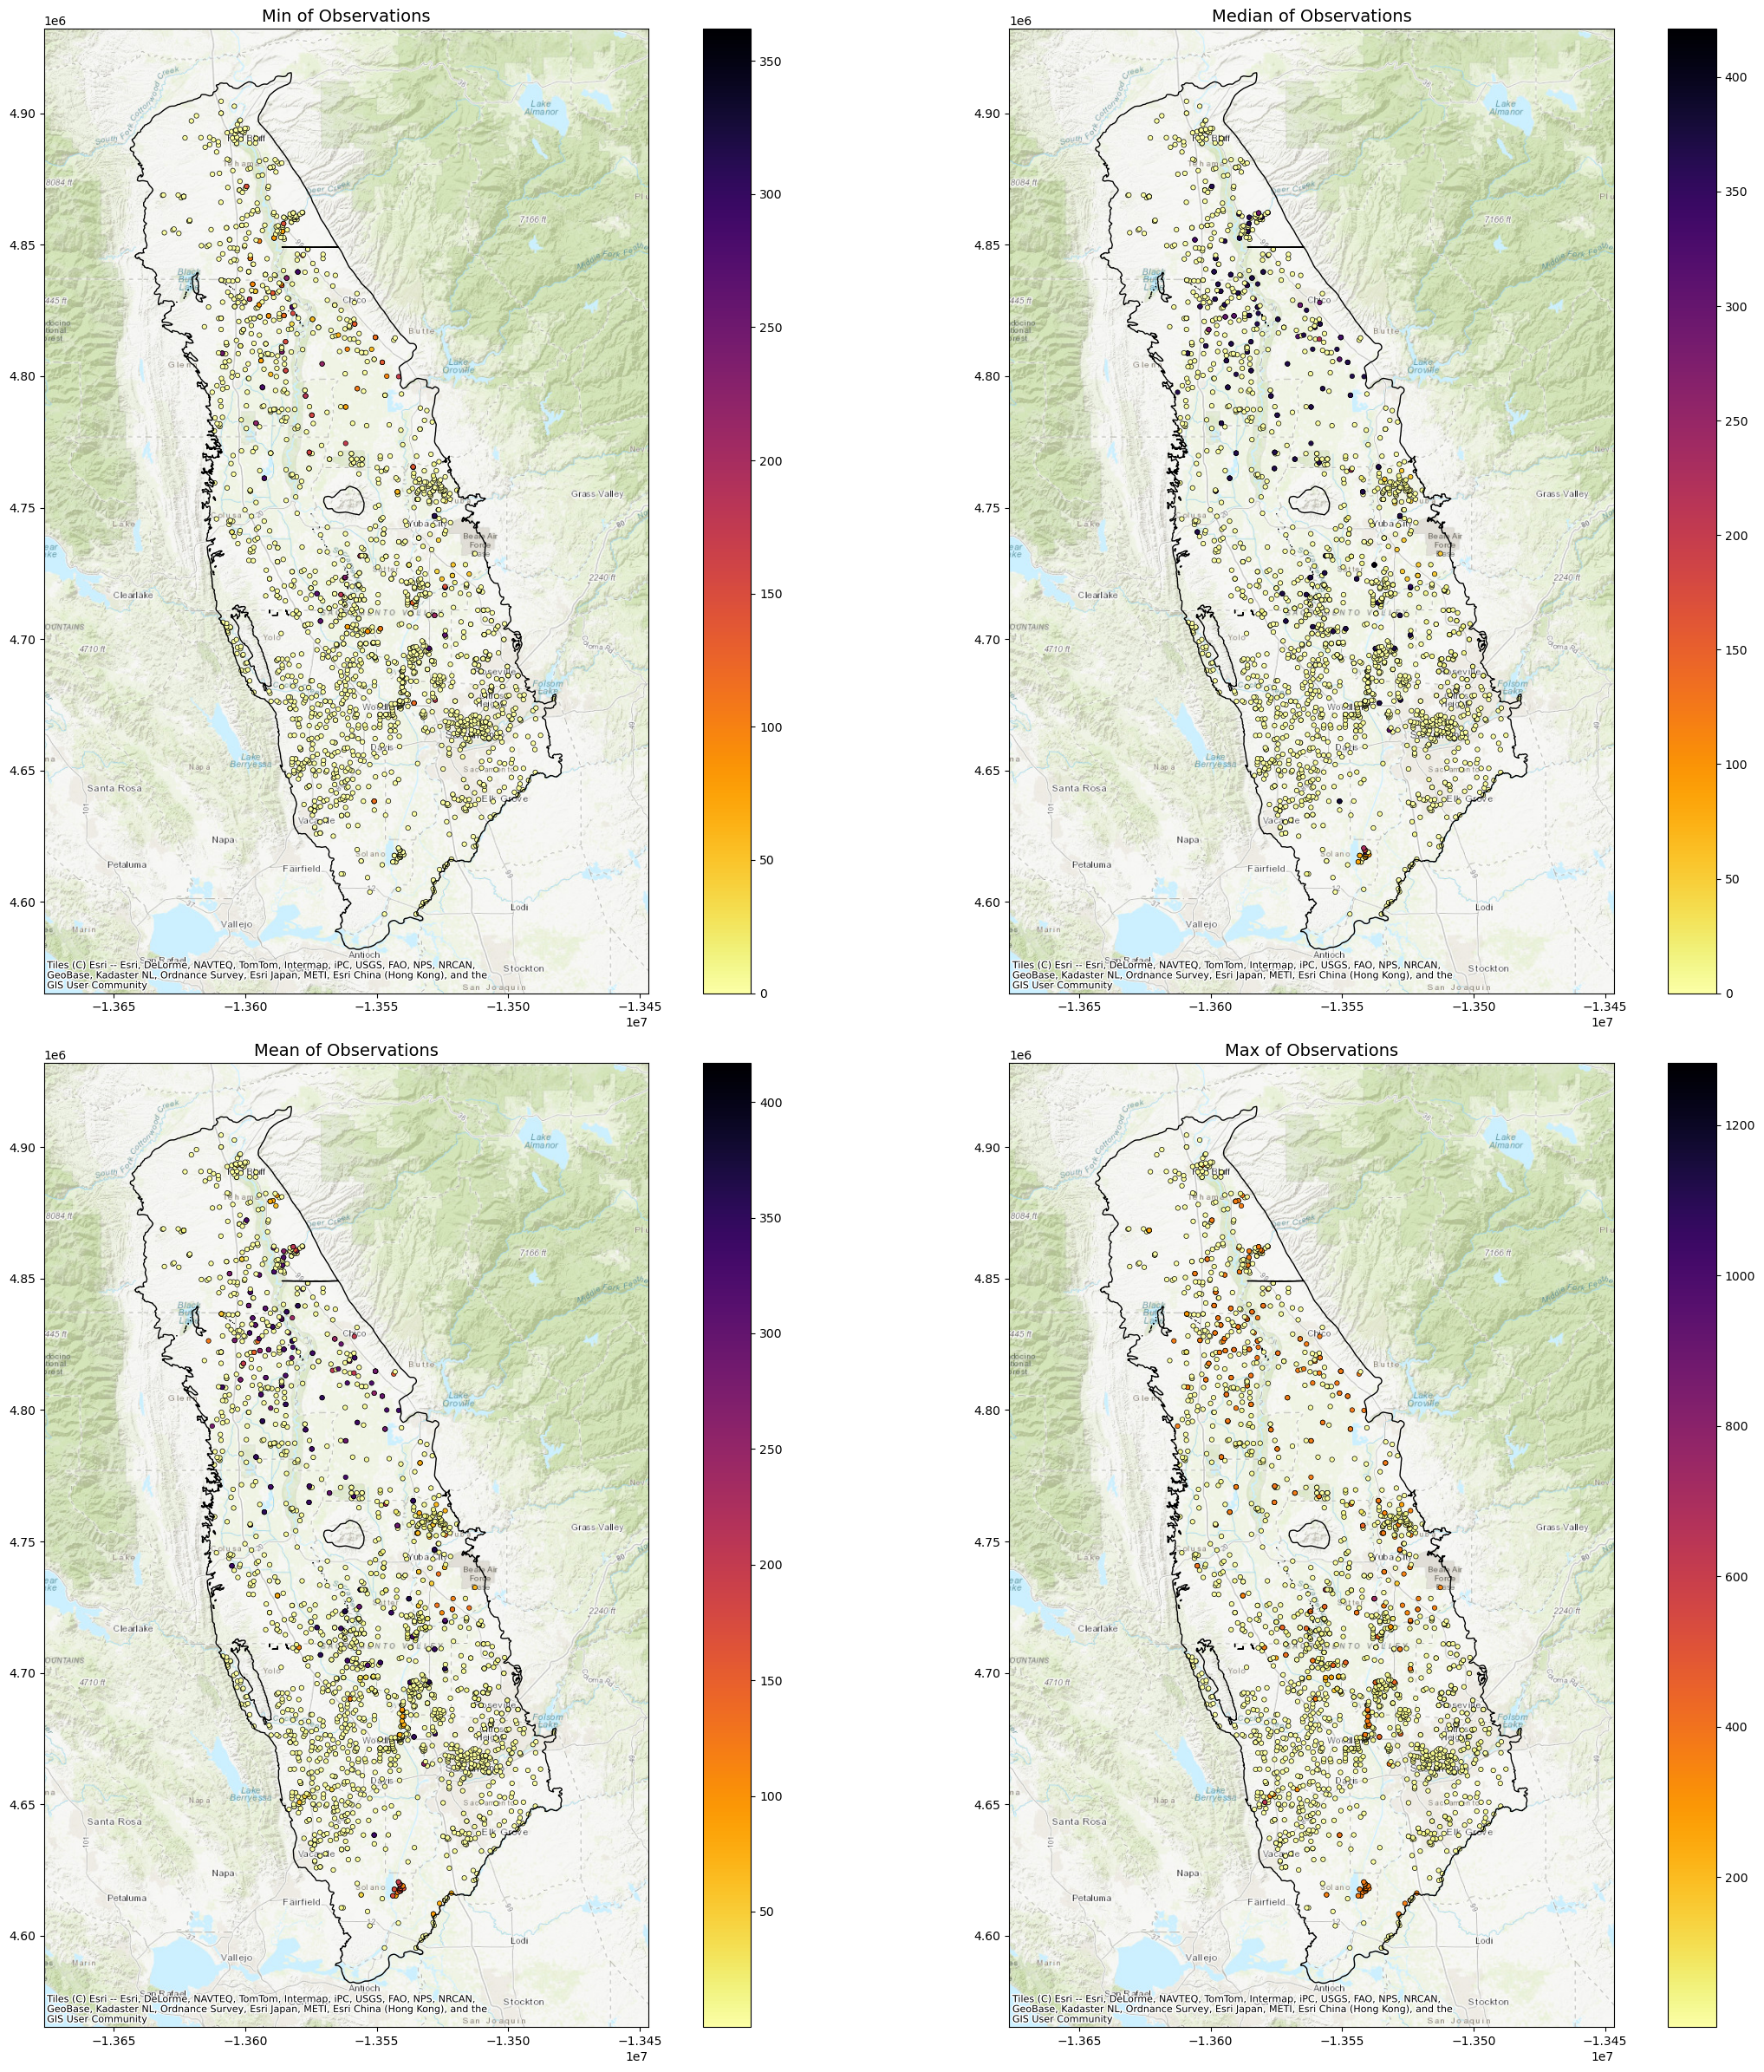

In [22]:
stations_gdf = gpd.GeoDataFrame(
    stations_5021,
    geometry=gpd.points_from_xy(stations_5021.longitude, stations_5021.latitude),
    crs="EPSG:4326"  # Assuming lat/lon in WGS84
)

# ------------------------------------------------------------------------
# 2) EXTRACT THE BASIN POLYGON FOR BASIN "5-021"
# ------------------------------------------------------------------------
filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']
# Dissolve into one polygon (in case the basin is multi-part)
larger_polygon = filtered_gdf.dissolve().geometry.iloc[0]
larger_polygon_gdf = gpd.GeoDataFrame(
    geometry=[larger_polygon],
    crs=filtered_gdf.crs
)

# ------------------------------------------------------------------------
# 3) CONVERT BOTH GeoDataFrames TO WEB MERCATOR (EPSG:3857)
# ------------------------------------------------------------------------
stations_gdf = stations_gdf.to_crs(epsg=3857)
larger_polygon_gdf = larger_polygon_gdf.to_crs(epsg=3857)

# ------------------------------------------------------------------------
# 4) CREATE NEW COLUMNS FOR MIN, MEDIAN, MEAN, AND MAX OF "observations_*"
# ------------------------------------------------------------------------
obs_cols = [col for col in stations_gdf.columns if col.startswith("observations_")]
stations_gdf["observations_min"] = stations_gdf[obs_cols].min(axis=1)
stations_gdf["observations_median"] = stations_gdf[obs_cols].median(axis=1)
stations_gdf["observations_mean"] = stations_gdf[obs_cols].mean(axis=1)
stations_gdf["observations_max"] = stations_gdf[obs_cols].max(axis=1)

# ------------------------------------------------------------------------
# 5) CREATE A FIGURE WITH 2 ROWS AND 2 COLUMNS OF SUBPLOTS (Square layout)
# ------------------------------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 24))
(ax1, ax2), (ax3, ax4) = axes

# We'll compute bounding box once so all subplots share the same extent
stations_bounds = stations_gdf.total_bounds  # [xmin, ymin, xmax, ymax]
polygon_bounds = larger_polygon_gdf.total_bounds

xmin = min(stations_bounds[0], polygon_bounds[0])
ymin = min(stations_bounds[1], polygon_bounds[1])
xmax = max(stations_bounds[2], polygon_bounds[2])
ymax = max(stations_bounds[3], polygon_bounds[3])

# Add margin around the bounds
x_margin = 0.20 * (xmax - xmin)
y_margin = 0.05 * (ymax - ymin)

xrange = (xmin - x_margin, xmax + x_margin)
yrange = (ymin - y_margin, ymax + y_margin)

# Helper function to add basemap and force square aspect ratio
def setup_axis(ax, title):
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    # Force the axis to be square
    ax.set_aspect('equal', adjustable='box')
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap)
    ax.set_title(title, fontsize=14)

# ------------------------------------------------------------------------
# MAP 1 (Top-Left): Min of Observations
# ------------------------------------------------------------------------
larger_polygon_gdf.boundary.plot(ax=ax1, color='black', linewidth=1)
stations_gdf.plot(
    column='observations_min',
    ax=ax1,
    cmap='inferno_r',  # Inverted inferno
    marker='o',
    markersize=15,
    legend=True,
    edgecolor='black',  # Thin black border around each point
    linewidth=0.5
)
setup_axis(ax1, "Min of Observations")

# ------------------------------------------------------------------------
# MAP 2 (Top-Right): Median of Observations
# ------------------------------------------------------------------------
larger_polygon_gdf.boundary.plot(ax=ax2, color='black', linewidth=1)
stations_gdf.plot(
    column='observations_median',
    ax=ax2,
    cmap='inferno_r',
    marker='o',
    markersize=15,
    legend=True,
    edgecolor='black',
    linewidth=0.5
)
setup_axis(ax2, "Median of Observations")

# ------------------------------------------------------------------------
# MAP 3 (Bottom-Left): Mean of Observations
# ------------------------------------------------------------------------
larger_polygon_gdf.boundary.plot(ax=ax3, color='black', linewidth=1)
stations_gdf.plot(
    column='observations_mean',
    ax=ax3,
    cmap='inferno_r',
    marker='o',
    markersize=15,
    legend=True,
    edgecolor='black',
    linewidth=0.5
)
setup_axis(ax3, "Mean of Observations")

# ------------------------------------------------------------------------
# MAP 4 (Bottom-Right): Max of Observations
# ------------------------------------------------------------------------
larger_polygon_gdf.boundary.plot(ax=ax4, color='black', linewidth=1)
stations_gdf.plot(
    column='observations_max',
    ax=ax4,
    cmap='inferno_r',
    marker='o',
    markersize=15,
    legend=True,
    edgecolor='black',
    linewidth=0.5
)
setup_axis(ax4, "Max of Observations")

plt.tight_layout()
plt.show()

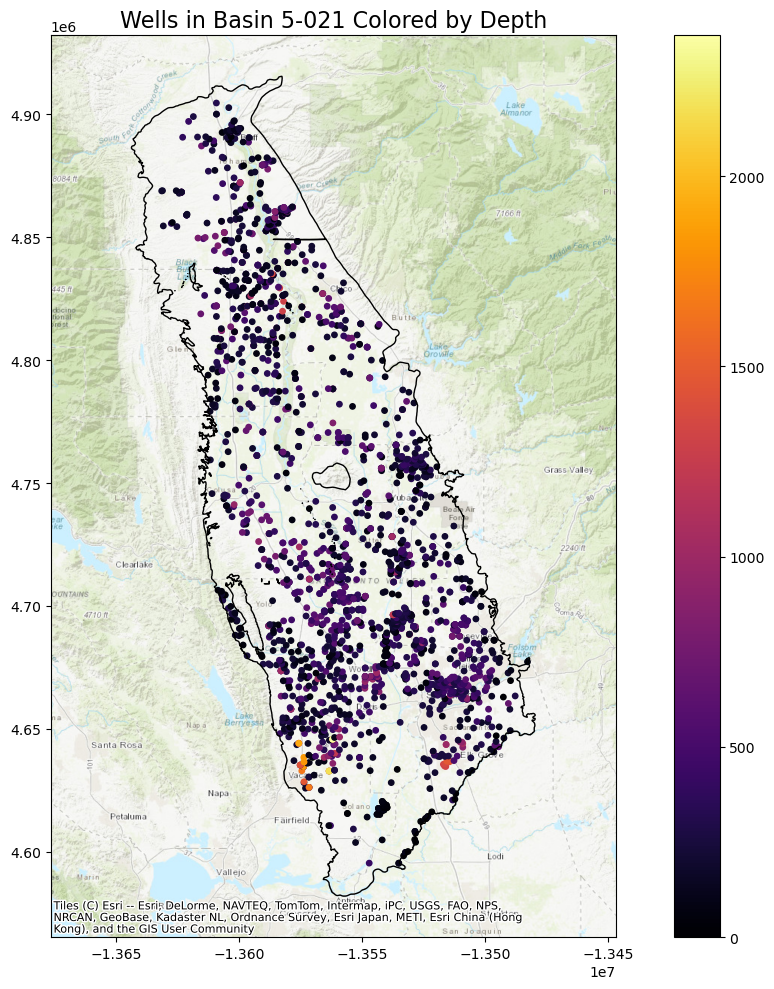

In [23]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# --- Convert your stations_5021 DataFrame into a GeoDataFrame ---
stations_gdf = gpd.GeoDataFrame(
    stations_5021,
    geometry=gpd.points_from_xy(stations_5021.longitude, stations_5021.latitude),
    crs="EPSG:4326"  # assuming the lat/lon are in WGS84
)

# --- Create the basin polygon for Basin 5-021 ---
filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']
larger_polygon = filtered_gdf.dissolve().geometry.iloc[0]
larger_polygon_gdf = gpd.GeoDataFrame(geometry=[larger_polygon], crs=filtered_gdf.crs)

# --- Convert both GeoDataFrames to Web Mercator (EPSG:3857) ---
stations_gdf = stations_gdf.to_crs(epsg=3857)
larger_polygon_gdf = larger_polygon_gdf.to_crs(epsg=3857)

# --- Plotting ---
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the basin polygon boundary and the well points.
larger_polygon_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
stations_gdf.plot(column='well_depth', ax=ax, cmap='inferno', marker='o', markersize=15, legend=True)

# Compute combined bounds from both the well points and basin polygon.
stations_bounds = stations_gdf.total_bounds  # [xmin, ymin, xmax, ymax]
polygon_bounds = larger_polygon_gdf.total_bounds
xmin = min(stations_bounds[0], polygon_bounds[0])
ymin = min(stations_bounds[1], polygon_bounds[1])
xmax = max(stations_bounds[2], polygon_bounds[2])
ymax = max(stations_bounds[3], polygon_bounds[3])

# Add a margin (5% of the total range) around the bounds.
x_margin = 0.20 * (xmax - xmin)
y_margin = 0.05 * (ymax - ymin)
ax.set_xlim(xmin - x_margin, xmax + x_margin)
ax.set_ylim(ymin - y_margin, ymax + y_margin)

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap)

ax.set_title('Wells in Basin 5-021 Colored by Depth', fontsize=16)
plt.tight_layout()

plt.show()

In [24]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
data = []
for year, sites in well_changes.items():
    for site, change in sites.items():
        precip = well_precipitation.get(year, {}).get(site, None)
        if precip is not None:
            data.append({
                'year': year,
                'site_code': site,
                'change_in_GWE': change,
                'avg_precip': precip
            })

df = pd.DataFrame(data)

wells = df['site_code'].unique()

well_pca_results = {}

for well in wells:
    df_well = df[df['site_code'] == well]
    
    if len(df_well) < 2:
        print(f"Not enough data for well {well} to perform PCA.")
        continue
    
    X_well = df_well[['avg_precip', 'change_in_GWE']].values
    X_centered = X_well - np.mean(X_well, axis=0)
    
    pca = PCA(n_components=2)
    pca.fit(X_centered)
    
    pc1 = pca.components_[0]

    gradient = pc1[1] / pc1[0] if pc1[0] != 0 else np.nan
    
    well_pca_results[well] = {
        'pc1': pc1,
        'gradient': gradient,
        'explained_variance': pca.explained_variance_ratio_
    }

In [25]:
ov25_5021["pca_gradient"] = ov25_5021['site_code'].map(lambda x: well_pca_results.get(x, {}).get("gradient", None))

In [26]:
ov25_5021

site_code  observations_2008  observations_2009  \
0    398543N1221535W004                369                367   
1    396087N1220456W002                358                372   
2    399733N1220069W001                370                372   
3    395118N1217880W003                299                287   
4    399624N1219946W001                303                219   
..                  ...                ...                ...   
163  388813N1218219W003                313                373   
164  388965N1219139W003                307                308   
165  388813N1217525W001                363                365   
166  386782N1215943W004                372                371   
167  386782N1215943W001                372                370   

     observations_2010  observations_2011  observations_2012  \
0                  367                367                369   
1                  366                369                367   
2                  236                369                368   
3                  369                106                377   
4                  222                367                366   
..                 ...                ...                ...   
163                372                325                 76   
164                372                330                368   
165                365                374                378   
166                375                371                370   
167                375                371                 87   

     observations_2013  observations_2014  observations_2015  \
0                  367                367                290   
1                  387                369                366   
2                  367                369                366   
3                  369                370                371   
4                  367                369                367   
..                 ...                ...                ...   
163                335                222                366   
164                374                370                374   
165                377                373                371   
166                371                369                294   
167                193                369                374   

     observations_2016  ...  observations_2020  observations_2021  \
0                  374  ...                193                181   
1                  346  ...                369                323   
2                  221  ...                369                310   
3                  362  ...                370                370   
4                  369  ...                369                368   
..                 ...  ...                ...                ...   
163                372  ...                368                369   
164                267  ...                367                400   
165                263  ...                365                430   
166                118  ...                379                427   
167                372  ...                378                427   

     observations_2022  observations_2023  observations_2024  latitude  \
0                  104                375                302  39.85430   
1                  137                368                295  39.60870   
2                  368                368                273  39.97328   
3                  370                366                370  39.51180   
4                  368                368                348  39.96247   
..                 ...                ...                ...       ...   
163                371                368                370  38.88130   
164                376                367                285  38.89650   
165                373                367                 86  38.86903   
166                373                358                369  38.67820   
167                373                366           

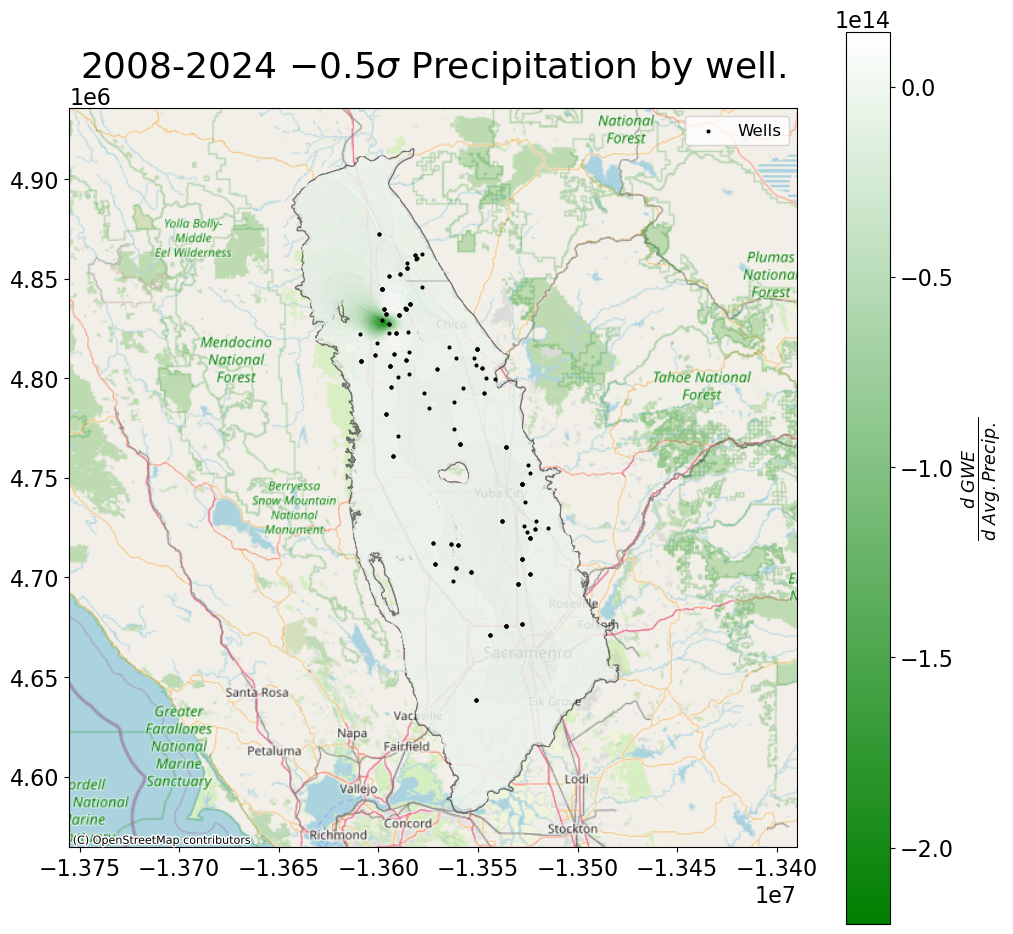

In [33]:
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 26,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.titlesize': 32
})

filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']
larger_polygon = filtered_gdf.dissolve().geometry.iloc[0]
larger_polygon_gdf = gpd.GeoDataFrame(
    geometry=[larger_polygon],
    crs=filtered_gdf.crs
)
larger_polygon_gdf = larger_polygon_gdf.to_crs(epsg=32633)
bounds = larger_polygon_gdf.total_bounds

wells_gdf = gpd.GeoDataFrame(
    ov25_5021,
    geometry=gpd.points_from_xy(
        ov25_5021['longitude'], 
        ov25_5021['latitude']
    ),
    crs="EPSG:4326"
)
wells_gdf = wells_gdf.to_crs(larger_polygon_gdf.crs)

x = wells_gdf.geometry.x
y = wells_gdf.geometry.y
z_slope = -np.exp(-wells_gdf['gradient'])

grid_x = np.linspace(bounds[0], bounds[2], num=100)
grid_y = np.linspace(bounds[1], bounds[3], num=100)

ok_slope = OrdinaryKriging(x, y, z_slope, variogram_model='linear')
z_interp_slope, ss_slope = ok_slope.execute('grid', grid_x, grid_y)

xx, yy = np.meshgrid(grid_x, grid_y)

grid_points = np.vstack((xx.flatten(), yy.flatten())).T
grid_points_gdf = gpd.GeoSeries(
    gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1]),
    crs=larger_polygon_gdf.crs
)
mask = grid_points_gdf.within(larger_polygon_gdf.geometry.iloc[0])
mask = mask.values.reshape(xx.shape)
z_interp_masked_slope = np.ma.masked_where(~mask, z_interp_slope)

slope_vals = z_interp_masked_slope.compressed()
min_val = slope_vals.min()
max_val = slope_vals.max()
norm = mpl.colors.TwoSlopeNorm(vmin=min_val, vcenter=(min_val+max_val)/2, vmax=max_val)

colors = ["green", "white"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("brown_white_green", colors)

larger_polygon_3857 = larger_polygon_gdf.to_crs(epsg=3857)
wells_gdf_3857 = wells_gdf.to_crs(epsg=3857)

transformer = Transformer.from_crs("EPSG:32633", "EPSG:3857", always_xy=True)
xx_3857, yy_3857 = transformer.transform(xx, yy)

fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)

larger_polygon_3857.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

contour_slope = ax.contourf(
    xx_3857, yy_3857,
    z_interp_masked_slope,
    levels=50,
    cmap=cmap,
    norm=norm,
    alpha=0.7
)

wells_gdf_3857.plot(ax=ax, marker='.', color='black', markersize=15, label='Wells')
ctx.add_basemap(ax, crs=larger_polygon_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(r"$\frac{d\ GWE}{d\ Avg. Precip.}$", fontsize=16)
ax.set_aspect('equal')
ax.legend(fontsize=12)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(
    sm, 
    ax=ax,
    fraction=0.1,
    shrink=0.9,
    pad=0.02
)
cbar.set_label(r"$\frac{d\ GWE}{d\ Avg. Precip.}$", fontsize=18)

plt.title(f"2008-2024 $-0.5 \sigma$ Precipitation by well.")
plt.show()

In [47]:
wells = {}
for year, sites in well_precipitation.items():
    for site, precip in sites.items():
        wells.setdefault(site, []).append((year, precip))

SD_above = {}
for site, values in wells.items():
    precip_values = [precip for _, precip in values]
    mean_val = np.mean(precip_values)
    std_val = np.std(precip_values)
    threshold = mean_val + 0.5 * std_val
    SD_above[site] = [year for year, precip in values if precip < threshold]

In [48]:
gradients = {}
for site, years in SD_above.items():
    x = []
    y = []
    for year in years:
        if (year in well_precipitation and site in well_precipitation[year] and
            year in well_changes and site in well_changes[year]):
            x.append(well_precipitation[year][site])
            y.append(well_changes[year][site])
    if len(x) > 1:
        reg_result = linregress(x, y)
        gradients[site] = {"slope": reg_result.slope, "p_value": reg_result.pvalue}
    else:
        gradients[site] = {"slope": None, "p_value": None}

In [49]:
ov25_5021['gradient_above'] = ov25_5021['site_code'].map(lambda x: gradients.get(x, {}).get("slope", None))

In [50]:
ov25_5021

site_code  observations_2008  observations_2009  \
0    398543N1221535W004                369                367   
1    396087N1220456W002                358                372   
2    399733N1220069W001                370                372   
3    395118N1217880W003                299                287   
4    399624N1219946W001                303                219   
..                  ...                ...                ...   
163  388813N1218219W003                313                373   
164  388965N1219139W003                307                308   
165  388813N1217525W001                363                365   
166  386782N1215943W004                372                371   
167  386782N1215943W001                372                370   

     observations_2010  observations_2011  observations_2012  \
0                  367                367                369   
1                  366                369                367   
2                  236                369                368   
3                  369                106                377   
4                  222                367                366   
..                 ...                ...                ...   
163                372                325                 76   
164                372                330                368   
165                365                374                378   
166                375                371                370   
167                375                371                 87   

     observations_2013  observations_2014  observations_2015  \
0                  367                367                290   
1                  387                369                366   
2                  367                369                366   
3                  369                370                371   
4                  367                369                367   
..                 ...                ...                ...   
163                335                222                366   
164                374                370                374   
165                377                373                371   
166                371                369                294   
167                193                369                374   

     observations_2016  ...  observations_2021  observations_2022  \
0                  374  ...                181                104   
1                  346  ...                323                137   
2                  221  ...                310                368   
3                  362  ...                370                370   
4                  369  ...                368                368   
..                 ...  ...                ...                ...   
163                372  ...                369                371   
164                267  ...                400                376   
165                263  ...                430                373   
166                118  ...                427                373   
167                372  ...                427                373   

     observations_2023  observations_2024  latitude  longitude  well_depth  \
0                  375                302  39.85430 -122.15350       182.0   
1                  368                295  39.60870 -122.04560       160.0   
2                  368                273  39.97328 -122.00688       330.0   
3                  366                370  39.51180 -121.78800       192.0   
4                  368                348  39.96247 -121.99465       960.0   
..                 ...                ...       ...        ...         ...   
163                368                370  38.88130 -121.82190       380.0   
164                367                285  38.89650 -121.91390       300.0   
165                367                 86  38.86903 -121.75250        68.0   
166                358                369  38.67820 -121.59430       200.0   
167     

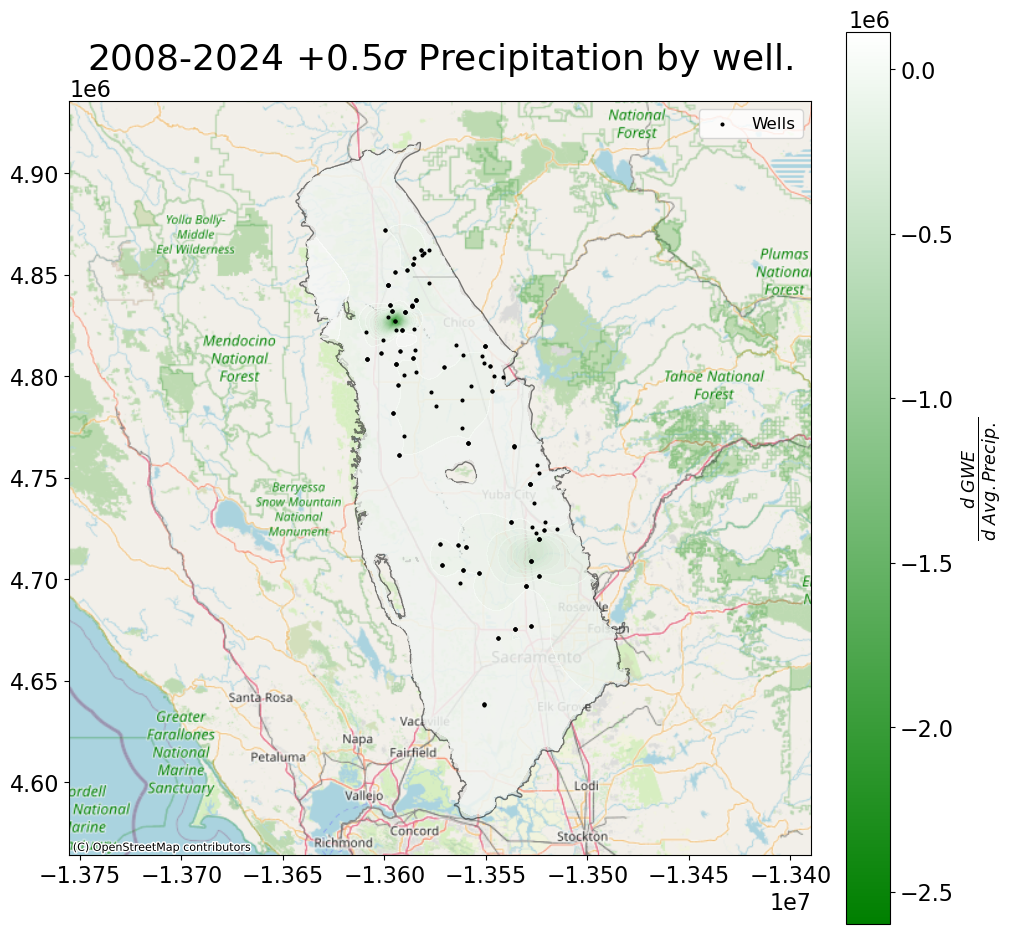

In [55]:
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 26,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.titlesize': 32
})

filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']
larger_polygon = filtered_gdf.dissolve().geometry.iloc[0]
larger_polygon_gdf = gpd.GeoDataFrame(
    geometry=[larger_polygon],
    crs=filtered_gdf.crs
)
larger_polygon_gdf = larger_polygon_gdf.to_crs(epsg=32633)
bounds = larger_polygon_gdf.total_bounds

wells_gdf = gpd.GeoDataFrame(
    ov25_5021,
    geometry=gpd.points_from_xy(
        ov25_5021['longitude'], 
        ov25_5021['latitude']
    ),
    crs="EPSG:4326"
)
wells_gdf = wells_gdf.to_crs(larger_polygon_gdf.crs)

x = wells_gdf.geometry.x
y = wells_gdf.geometry.y
z_slope = -np.exp(-wells_gdf['gradient_above'])

grid_x = np.linspace(bounds[0], bounds[2], num=100)
grid_y = np.linspace(bounds[1], bounds[3], num=100)

ok_slope = OrdinaryKriging(x, y, z_slope, variogram_model='linear')
z_interp_slope, ss_slope = ok_slope.execute('grid', grid_x, grid_y)

xx, yy = np.meshgrid(grid_x, grid_y)

grid_points = np.vstack((xx.flatten(), yy.flatten())).T
grid_points_gdf = gpd.GeoSeries(
    gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1]),
    crs=larger_polygon_gdf.crs
)
mask = grid_points_gdf.within(larger_polygon_gdf.geometry.iloc[0])
mask = mask.values.reshape(xx.shape)
z_interp_masked_slope = np.ma.masked_where(~mask, z_interp_slope)

slope_vals = z_interp_masked_slope.compressed()
min_val = slope_vals.min()
max_val = slope_vals.max()
norm = mpl.colors.TwoSlopeNorm(vmin=min_val, vcenter=(min_val+max_val)/2, vmax=max_val)

colors = ["green", "white"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("brown_white_green", colors)

larger_polygon_3857 = larger_polygon_gdf.to_crs(epsg=3857)
wells_gdf_3857 = wells_gdf.to_crs(epsg=3857)

transformer = Transformer.from_crs("EPSG:32633", "EPSG:3857", always_xy=True)
xx_3857, yy_3857 = transformer.transform(xx, yy)

fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)

larger_polygon_3857.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

contour_slope = ax.contourf(
    xx_3857, yy_3857,
    z_interp_masked_slope,
    levels=50,
    cmap=cmap,
    norm=norm,
    alpha=0.7
)

wells_gdf_3857.plot(ax=ax, marker='.', color='black', markersize=15, label='Wells')
ctx.add_basemap(ax, crs=larger_polygon_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(r"$\frac{d\ GWE}{d\ Avg. Precip.}$", fontsize=16)
ax.set_aspect('equal')
ax.legend(fontsize=12)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(
    sm, 
    ax=ax,
    fraction=0.1,
    shrink=0.9,
    pad=0.02
)
cbar.set_label(r"$\frac{d\ GWE}{d\ Avg. Precip.}$", fontsize=18)

plt.title(f"2008-2024 $+0.5 \sigma$ Precipitation by well.")
plt.show()

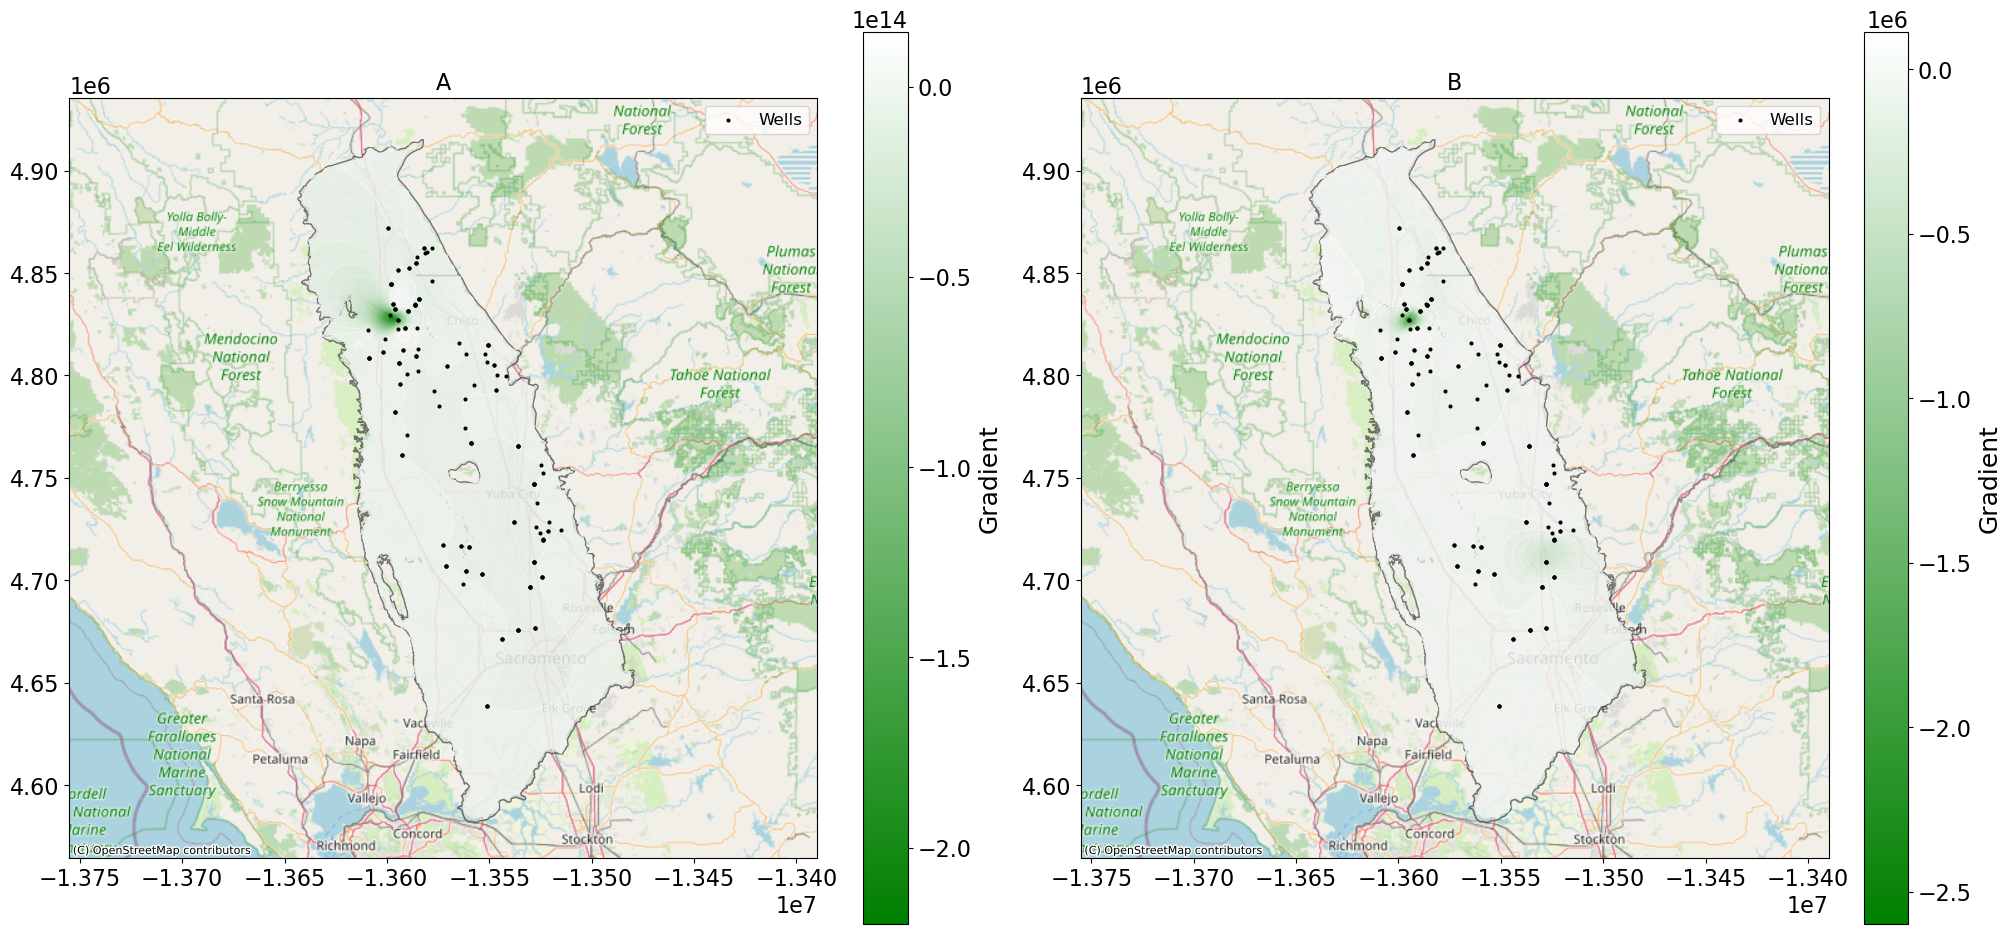

In [57]:
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 26,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.titlesize': 32
})

# Filter and prepare the polygon
filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']
larger_polygon = filtered_gdf.dissolve().geometry.iloc[0]
larger_polygon_gdf = gpd.GeoDataFrame(geometry=[larger_polygon], crs=filtered_gdf.crs)
larger_polygon_gdf = larger_polygon_gdf.to_crs(epsg=32633)
bounds = larger_polygon_gdf.total_bounds

# Prepare wells GeoDataFrame and project
wells_gdf = gpd.GeoDataFrame(
    ov25_5021,
    geometry=gpd.points_from_xy(ov25_5021['longitude'], ov25_5021['latitude']),
    crs="EPSG:4326"
)
wells_gdf = wells_gdf.to_crs(larger_polygon_gdf.crs)

# Define x and y coordinates from wells
x = wells_gdf.geometry.x
y = wells_gdf.geometry.y

# Define grid for interpolation
grid_x = np.linspace(bounds[0], bounds[2], num=100)
grid_y = np.linspace(bounds[1], bounds[3], num=100)
xx, yy = np.meshgrid(grid_x, grid_y)

# Create a GeoSeries of grid points and mask those outside the larger polygon
grid_points = np.vstack((xx.flatten(), yy.flatten())).T
grid_points_gdf = gpd.GeoSeries(gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1]), crs=larger_polygon_gdf.crs)
mask = grid_points_gdf.within(larger_polygon_gdf.geometry.iloc[0])
mask = mask.values.reshape(xx.shape)

# Create a color map (you can adjust these colors as needed)
colors = ["green", "white"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("brown_white_green", colors)

# Prepare CRS conversion to web mercator for plotting with basemap
larger_polygon_3857 = larger_polygon_gdf.to_crs(epsg=3857)
wells_gdf_3857 = wells_gdf.to_crs(epsg=3857)
transformer = Transformer.from_crs("EPSG:32633", "EPSG:3857", always_xy=True)
xx_3857, yy_3857 = transformer.transform(xx, yy)

# Create the side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)

#############################################
# Left plot: using the "gradient" column
#############################################
# Compute transformed values for "gradient"
z_gradient = -np.exp(-wells_gdf['gradient'])
# Ordinary Kriging interpolation
ok_gradient = OrdinaryKriging(x, y, z_gradient, variogram_model='linear')
z_interp_gradient, ss_gradient = ok_gradient.execute('grid', grid_x, grid_y)
# Mask values outside the polygon
z_interp_masked_gradient = np.ma.masked_where(~mask, z_interp_gradient)
# Set normalization for the colormap
grad_vals = z_interp_masked_gradient.compressed()
min_val_grad = grad_vals.min()
max_val_grad = grad_vals.max()
norm_grad = mpl.colors.TwoSlopeNorm(vmin=min_val_grad,
                                      vcenter=(min_val_grad + max_val_grad)/2,
                                      vmax=max_val_grad)

# Plot polygon, contour and wells
larger_polygon_3857.plot(ax=ax1, color='lightgray', edgecolor='black', alpha=0.5)
contour_grad = ax1.contourf(xx_3857, yy_3857,
                            z_interp_masked_gradient,
                            levels=50,
                            cmap=cmap,
                            norm=norm_grad,
                            alpha=0.7)
wells_gdf_3857.plot(ax=ax1, marker='.', color='black', markersize=15, label='Wells')
ctx.add_basemap(ax1, crs=larger_polygon_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_title("A", fontsize=16)
ax1.set_aspect('equal')
ax1.legend(fontsize=12)
# Add colorbar to the left plot
sm_grad = mpl.cm.ScalarMappable(norm=norm_grad, cmap=cmap)
sm_grad.set_array([])
cbar1 = fig.colorbar(sm_grad, ax=ax1, fraction=0.1, shrink=0.9, pad=0.02)
cbar1.set_label("Gradient", fontsize=18)

#############################################
# Right plot: using the "gradient_above" column
#############################################
# Compute transformed values for "gradient_above"
z_slope = -np.exp(-wells_gdf['gradient_above'])
# Ordinary Kriging interpolation
ok_slope = OrdinaryKriging(x, y, z_slope, variogram_model='linear')
z_interp_slope, ss_slope = ok_slope.execute('grid', grid_x, grid_y)
# Mask values outside the polygon
z_interp_masked_slope = np.ma.masked_where(~mask, z_interp_slope)
# Set normalization for the colormap
slope_vals = z_interp_masked_slope.compressed()
min_val_slope = slope_vals.min()
max_val_slope = slope_vals.max()
norm_slope = mpl.colors.TwoSlopeNorm(vmin=min_val_slope,
                                       vcenter=(min_val_slope + max_val_slope)/2,
                                       vmax=max_val_slope)

# Plot polygon, contour and wells
larger_polygon_3857.plot(ax=ax2, color='lightgray', edgecolor='black', alpha=0.5)
contour_slope = ax2.contourf(xx_3857, yy_3857,
                             z_interp_masked_slope,
                             levels=50,
                             cmap=cmap,
                             norm=norm_slope,
                             alpha=0.7)
wells_gdf_3857.plot(ax=ax2, marker='.', color='black', markersize=15, label='Wells')
ctx.add_basemap(ax2, crs=larger_polygon_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_title("B", fontsize=16)
ax2.set_aspect('equal')
ax2.legend(fontsize=12)
# Add colorbar to the right plot
sm_slope = mpl.cm.ScalarMappable(norm=norm_slope, cmap=cmap)
sm_slope.set_array([])
cbar2 = fig.colorbar(sm_slope, ax=ax2, fraction=0.1, shrink=0.9, pad=0.02)
cbar2.set_label("Gradient", fontsize=18)

# Add a suptitle if desired
plt.show()